### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [4]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers, Policy
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 1) Initialize Model

In [5]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 50000

In [6]:
for policy in model.levers:
    print(repr(policy))

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False)
IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False)
IntegerParameter('EWS_DaysToThreat', 0, 1, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False)
IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False)
IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False)
IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.3_DikeIncrease 0'

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [7]:


ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 6) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))



[MainProcess/INFO] pool started with 6 workers
50060it [1:55:37,  7.22it/s]                                                   
[MainProcess/INFO] optimization completed, found 8108 solutions
[MainProcess/INFO] terminating pool


In [8]:
# final result data set
results = pd.read_csv("results/optimization_6_50000_noEWS.csv")
results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,1,1,1,1,1,0,0,3,1,...,2.029929e+07,0.012657,6.099298e+06,0.000000e+00,0.001223,0.000000e+00,4.027367e+07,0.000000,710400000.0,0.0
1,1,1,0,0,0,0,0,0,3,6,...,3.139880e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,3.337712e+07,0.000000,84600000.0,0.0
2,2,1,1,1,1,1,0,1,4,1,...,2.029929e+07,0.012657,6.099298e+06,0.000000e+00,0.001223,0.000000e+00,5.817663e+07,0.000000,710400000.0,0.0
3,3,0,1,0,0,1,1,5,1,0,...,0.000000e+00,0.091438,2.591086e+06,0.000000e+00,0.000511,0.000000e+00,2.757823e+07,0.000000,473900000.0,0.0
4,4,1,0,0,0,0,1,0,4,0,...,0.000000e+00,0.092239,0.000000e+00,1.426165e+07,0.000000,0.000000e+00,3.337712e+07,0.000000,84600000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,0,0,1,1,1,1,2,4,0,...,0.000000e+00,0.030772,0.000000e+00,1.258646e+07,0.000000,1.462522e+07,0.000000e+00,0.005190,408000000.0,0.0
8104,8104,1,0,1,0,0,0,0,10,3,...,2.419803e+07,0.000000,7.114656e+06,6.320800e+06,0.001575,5.084397e+07,2.503721e+07,0.018235,115300000.0,0.0
8105,8105,1,0,0,1,0,0,2,3,1,...,2.029929e+07,0.031913,9.156879e+06,0.000000e+00,0.001797,1.462522e+07,0.000000e+00,0.005190,205800000.0,0.0
8106,8106,1,0,1,1,1,0,1,5,6,...,3.139880e+07,0.000000,3.705277e+06,6.320800e+06,0.000780,0.000000e+00,2.757823e+07,0.000000,492600000.0,0.0


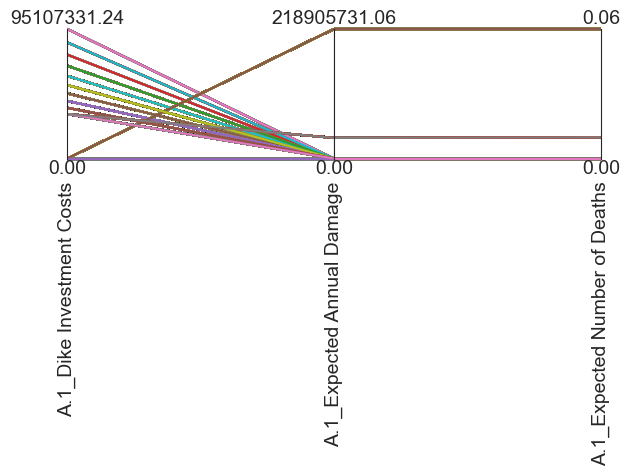

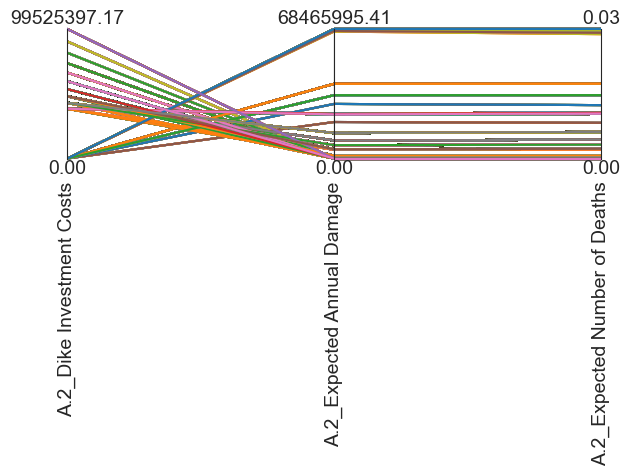

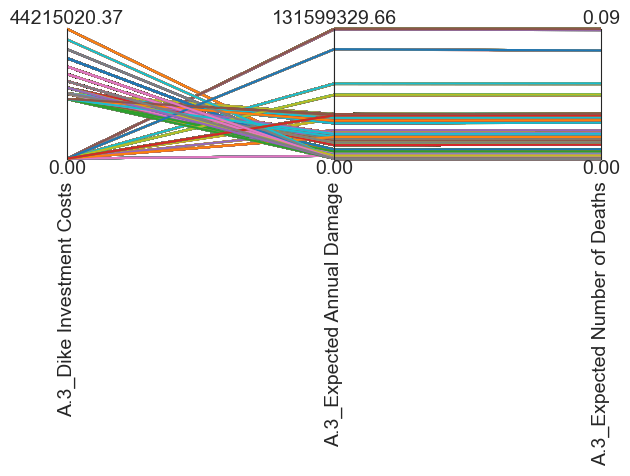

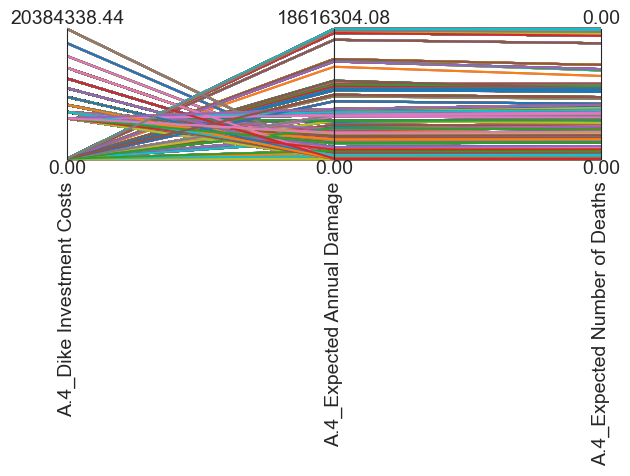

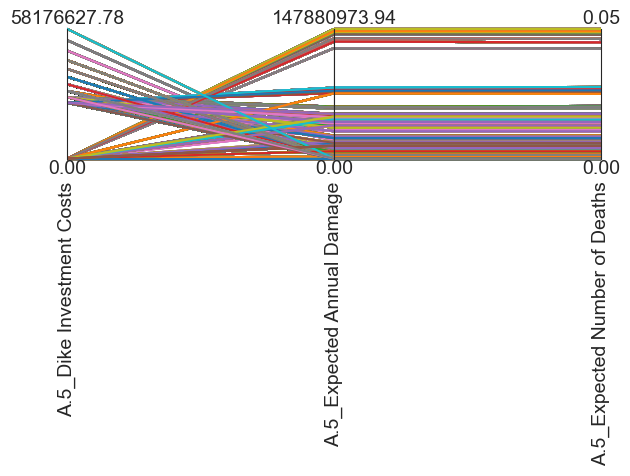

In [9]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = results.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [10]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)


results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
0,0,1,1,1,1,1,0,0,3,1,...,4.027367e+07,0.000000,710400000.0,0.0,0.013272,1.951891e+07,6.814199e+07,0.001223,6.099298e+06,4.027367e+07
1,1,1,0,0,0,0,0,0,3,6,...,3.337712e+07,0.000000,84600000.0,0.0,0.001920,4.924467e+06,7.924150e+07,0.000000,0.000000e+00,4.444589e+07
2,2,1,1,1,1,1,0,1,4,1,...,5.817663e+07,0.000000,710400000.0,0.0,0.012657,1.793119e+07,1.063528e+08,0.001223,6.099298e+06,5.817663e+07
3,3,0,1,0,0,1,1,5,1,0,...,2.757823e+07,0.000000,473900000.0,0.0,0.100457,1.546264e+08,9.221763e+07,0.000511,2.591086e+06,2.757823e+07
4,4,1,0,0,0,0,1,0,4,0,...,3.337712e+07,0.000000,84600000.0,0.0,0.092239,1.315993e+08,5.335857e+07,0.000000,0.000000e+00,4.763877e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,0,0,1,1,1,1,2,4,0,...,0.000000e+00,0.005190,408000000.0,0.0,0.030772,4.394483e+07,9.061378e+07,0.005190,1.462522e+07,1.258646e+07
8104,8104,1,0,1,0,0,0,0,10,3,...,2.503721e+07,0.018235,115300000.0,0.0,0.000000,0.000000e+00,1.237234e+08,0.019810,5.795862e+07,3.135801e+07
8105,8105,1,0,0,1,0,0,2,3,1,...,0.000000e+00,0.005190,205800000.0,0.0,0.033815,4.974352e+07,1.053972e+08,0.006986,2.378210e+07,0.000000e+00
8106,8106,1,0,1,1,1,0,1,5,6,...,2.757823e+07,0.000000,492600000.0,0.0,0.000000,0.000000e+00,1.235038e+08,0.000780,3.705277e+06,3.389903e+07


In [11]:
#Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.1
distribution_threshold_damages = 0.1
distribution_threshold_investment = 0.1
#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Gelderland_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Gelderland_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]

policies

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment
411,411,0,1,1,0,0,1,0,4,3,...,2.757823e+07,0.021521,248500000.0,0.0,0.0,0.0,7.755661e+07,0.021647,5.983177e+07,3.603164e+07
69,69,1,0,1,1,0,1,0,4,3,...,4.027367e+07,0.000000,236500000.0,0.0,0.0,0.0,7.755661e+07,0.000335,1.488454e+06,4.760575e+07
155,155,1,0,0,1,0,1,0,4,4,...,3.337712e+07,0.000000,205800000.0,0.0,0.0,0.0,7.976195e+07,0.002049,1.005581e+07,3.337712e+07
241,241,0,1,0,1,0,1,0,4,4,...,2.503721e+07,0.018131,339000000.0,0.0,0.0,0.0,7.976195e+07,0.018131,5.048813e+07,3.929887e+07
764,764,1,0,1,1,0,1,0,4,4,...,2.757823e+07,0.000000,236500000.0,0.0,0.0,0.0,7.976195e+07,0.001417,6.659949e+06,3.389903e+07
203,203,1,0,1,1,0,0,0,4,5,...,2.503721e+07,0.018131,236500000.0,0.0,0.0,0.0,8.215697e+07,0.018131,5.048813e+07,3.473241e+07
39,39,1,0,0,0,0,0,0,4,5,...,2.503721e+07,0.027941,84600000.0,0.0,0.0,0.0,8.215697e+07,0.028884,8.170727e+07,3.236929e+07
198,198,1,0,0,1,0,1,0,4,5,...,4.027367e+07,0.000000,205800000.0,0.0,0.0,0.0,8.215697e+07,0.000000,0.000000e+00,4.872708e+07


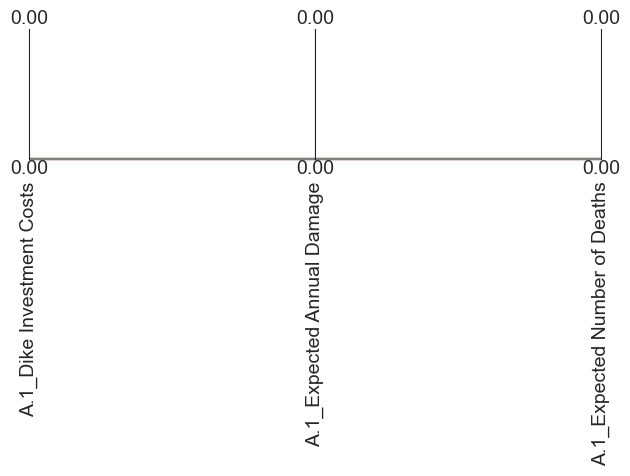

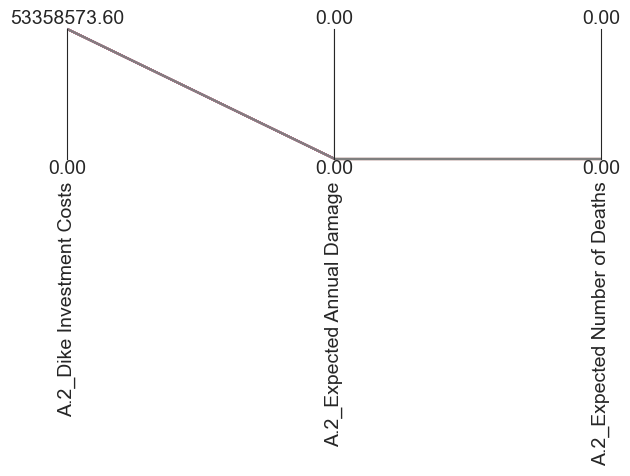

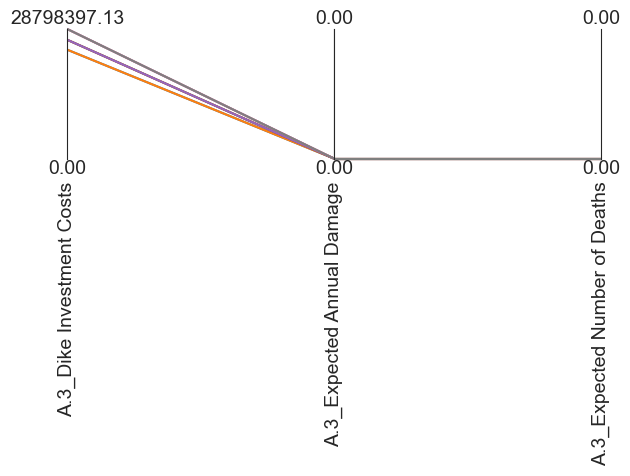

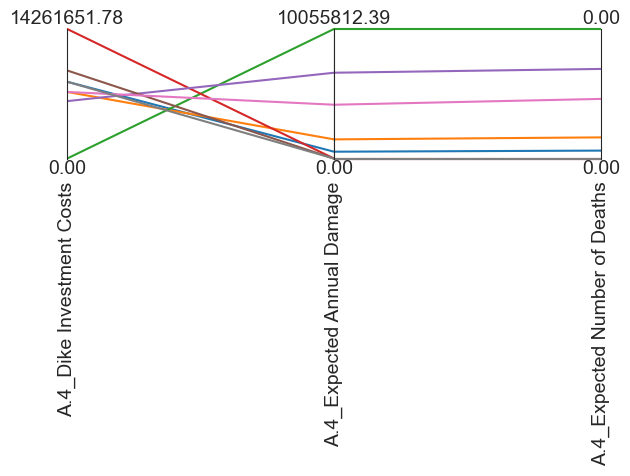

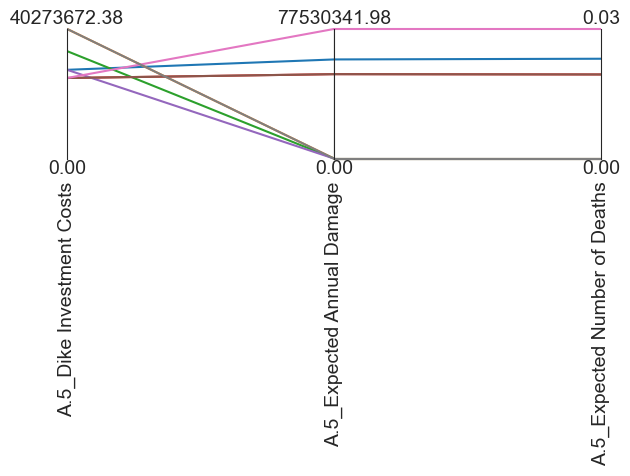

In [12]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = policies.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

#### 3b Robustness Analysis (Run Scenarios)

In [13]:

n_scenarios = 1000
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))


In [14]:

with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2.tar.gz')



[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [07:17<00:00, 18.28it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to c:\Users\varun\OneDrive\Desktop\model-based-decision-making\final_assignment\results\MORDM2.tar.gz


In [15]:
rob_results = load_results ('results/MORDM2.tar.gz')

[MainProcess/INFO] results loaded successfully from c:\Users\varun\OneDrive\Desktop\model-based-decision-making\final_assignment\results\MORDM2.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [16]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [17]:
experiments, outcomes = rob_results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
39,4.408373e+16,0.0,0.015474,2.176964e+14,0.0,0.000175,9.637559e+14,0.321847,0.002221,6.567285e+13,0.020486,1.276840e-05,3.640140e+15,0.186542,0.002480,0.0,0.0
69,4.408373e+16,0.0,0.015474,8.523306e+13,0.0,0.000072,1.369728e+15,0.090145,0.003122,3.367568e+13,0.020486,6.274757e-06,7.660034e+12,0.600124,0.000005,0.0,0.0
155,4.408373e+16,0.0,0.015474,1.700470e+14,0.0,0.000137,1.620063e+15,0.098360,0.003896,1.324275e+14,0.000000,2.253934e-05,4.306350e+13,0.000000,0.000031,0.0,0.0
198,4.408373e+16,0.0,0.015474,1.700470e+14,0.0,0.000137,6.040229e+14,0.321847,0.001291,1.505497e+13,0.015746,2.867950e-06,9.239823e+12,0.600124,0.000006,0.0,0.0
203,4.408373e+16,0.0,0.015474,8.523306e+13,0.0,0.000072,1.634438e+14,0.321847,0.000288,6.028861e+12,0.000000,1.212040e-06,1.366568e+15,0.186542,0.000904,0.0,0.0
241,5.109438e+16,0.0,0.017852,1.647220e+14,0.0,0.000132,1.593753e+15,0.098360,0.003834,1.838864e+11,0.053129,3.434455e-08,1.237864e+15,0.186542,0.000838,0.0,0.0
411,5.109438e+16,0.0,0.017852,1.063632e+14,0.0,0.000088,2.033624e+15,0.090145,0.004799,2.891771e+13,0.015746,5.801975e-06,1.820073e+15,0.000000,0.001253,0.0,0.0
764,4.408373e+16,0.0,0.015474,8.523306e+13,0.0,0.000072,5.190575e+14,0.098360,0.001034,7.285392e+13,0.011773,1.296745e-05,4.400942e+14,0.000000,0.000294,0.0,0.0


c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


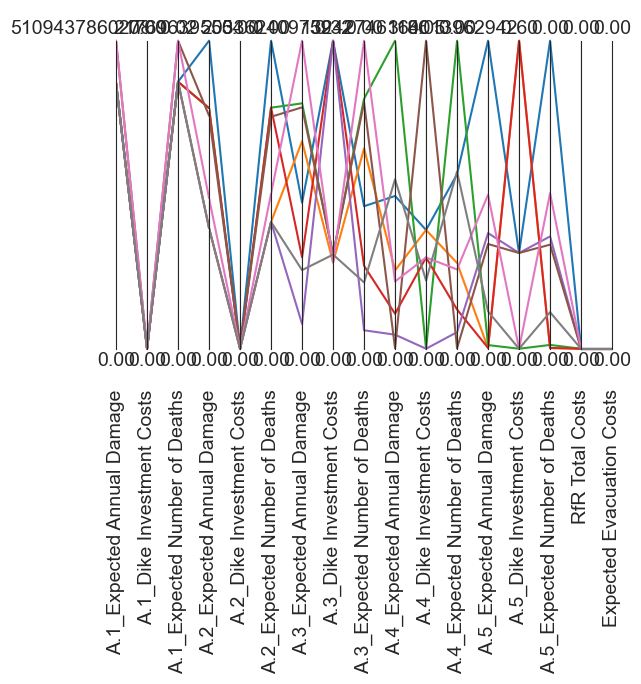

' for i in range(5):\n\n        data = policies.loc[:, [f"A.{i+1}_Dike Investment Costs",\n                               f"A.{i+1}_Expected Annual Damage",\n                               f"A.{i+1}_Expected Number of Deaths",\n                               ]]\n        \n        limits = parcoords.get_limits(data)\n        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",\n                               f"A.{i+1}_Expected Number of Deaths",\n                               f"A.{i+1}_Dike Investment Costs",\n                               ]] = 0\n\n        paraxes = parcoords.ParallelAxes(limits)\n        paraxes.plot(data)\n        \n        \n        plt.show() '

In [18]:

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()
#gives results across each of the dike rings for problem_formulation (3)
""" for i in range(5):

        data = policies.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show() """
        

##### 3c2 Calculate Regret

In [19]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [20]:
experiments, outcomes = rob_results
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # Convert your DataFrame to a numpy array before multi-dimensional indexing
    data_array = data.to_numpy()

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = np.abs(data_array.max(axis=1)[:, np.newaxis] - data_array)
    # Convert numpy array back to DataFrame
    outcome_regret_df = pd.DataFrame(outcome_regret, index=data.index, columns=data.columns)
    
    overall_regret[outcome.name] = outcome_regret_df
    max_regret[outcome.name] = outcome_regret_df.max()


visualize as heatmap

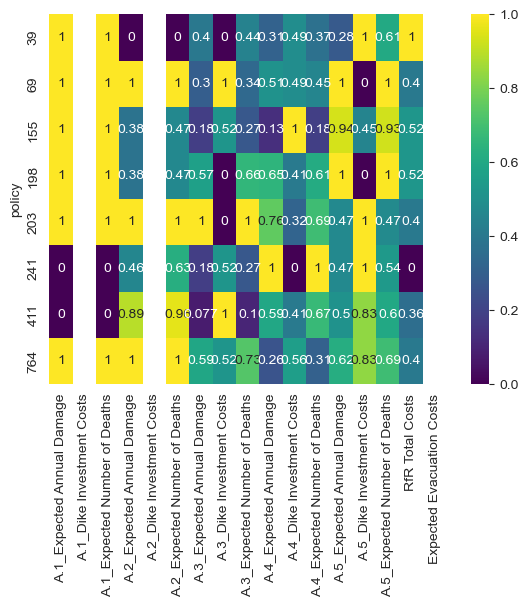

In [21]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:280: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


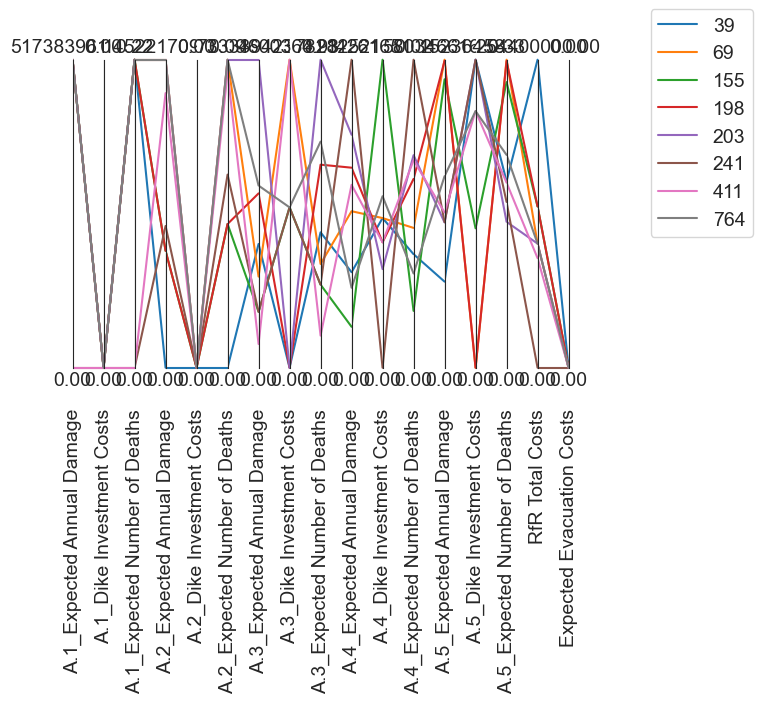

In [22]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()